## DataWhale AI 夏令营第二期--自然语言处理赛道--Task1笔记

### 1、赛事背景

目前神经机器翻译技术已经取得了很大的突破，但在特定领域或行业中，由于机器翻译难以保证术语的一致性，导致翻译效果还不够理想。对于术语名词、人名地名等机器翻译不准确的结果，可以通过术语词典进行纠正，避免了混淆或歧义，最大限度提高翻译质量。

### 2、赛事任务

基于术语词典干预的机器翻译挑战赛选择以英文为源语言，中文为目标语言的机器翻译。本次大赛除英文到中文的双语数据，还提供英中对照的术语词典。参赛队伍需要基于提供的训练数据样本从多语言机器翻译模型的构建与训练，并基于测试集以及术语词典，提供最终的翻译结果，数据包括：

·训练集：双语数据：中英14万余双语句对

·开发集：英中1000双语句对

·测试集：英中1000双语句对

·术语词典：英中2226条

### 3、赛事规则

#### 3.1数据说明

所有文件均为UTF-8编码，其中测评官方发放的训练集、开发集、测试集和术语词典皆为文本文件，格式如下所示。

训练集为双语数据，每行为一个句对样本，其格式如图所示。

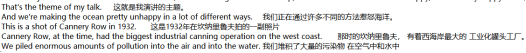

术语词典格式如图所示。

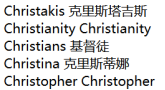

#### 3.2评估指标

对于参赛队伍提交的测试集翻译结果文件，采用自动评价指标BLUE-4进行评价，具体工具使用sacrebleu开源版本。

#### 3.3评测及排行

1）提供下载数据，选手在本地进行算法调试，在比赛页面提交结果。

2）排行按照得分从高到低排序，排行榜将选择团队的历史最优成绩进行排名。

### 4、提交要求

1、文件格式：txt格式，编码为UTF-8

2、文件大小：无要求

3、提交次数限制：每支队伍每天最多3次

4、文件详细说明：

1) 提交格式见图样例及example.txt文件（现在提交这个就可以）

   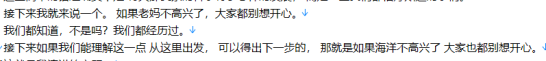

3) 进入决赛的队伍须提交技术说明文档：系统主要技术概述、重要参数说明、外部技术说明（开源代码或软件）


### 5、赛题解读

赛题是对文本进行翻译，将中文翻译成英文

使用训练集进行训练

训练完成后使用测试集进行测试，将翻译结果保存提交

### 6、baseline解读

In [ ]:
!pip install torchtext

安装torchtext用于文本处理

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from collections import Counter
import random
from torch.utils.data import Subset, DataLoader
import time

导入用到的库

In [ ]:
# 定义一个用于翻译任务的数据集类，继承自 PyTorch 的 Dataset 类
class TranslationDataset(Dataset):
    def __init__(self, filename, terminology):
        self.data = []  # 初始化数据列表
        # 读取文件并将每一行分割为英文和中文，添加到数据列表中
        with open(filename, 'r', encoding='utf-8') as f:
            for line in f:
                en, zh = line.strip().split('\t')
                self.data.append((en, zh))
        
        self.terminology = terminology  # 术语字典
        
        # 初始化英文和中文的分词器
        self.en_tokenizer = get_tokenizer('basic_english')
        self.zh_tokenizer = list  # 中文使用字符级分词
        
        # 使用 Counter 统计英文和中文词汇的频率
        en_vocab = Counter(self.terminology.keys())  # 英文词汇表初始化为术语
        zh_vocab = Counter()
        
        for en, zh in self.data:
            en_vocab.update(self.en_tokenizer(en))  # 更新英文词汇表
            zh_vocab.update(self.zh_tokenizer(zh))  # 更新中文词汇表
        
        # 创建词汇表，包括填充符、起始符、结束符和最常见的词汇
        self.en_vocab = ['<pad>', '<sos>', '<eos>'] + list(self.terminology.keys()) + [word for word, _ in en_vocab.most_common(10000)]
        self.zh_vocab = ['<pad>', '<sos>', '<eos>'] + [word for word, _ in zh_vocab.most_common(10000)]
        
        # 创建词汇到索引的映射
        self.en_word2idx = {word: idx for idx, word in enumerate(self.en_vocab)}
        self.zh_word2idx = {word: idx for idx, word in enumerate(self.zh_vocab)}

    def __len__(self):
        # 返回数据集中样本的数量
        return len(self.data)

    def __getitem__(self, idx):
        # 根据索引返回一个样本
        en, zh = self.data[idx]
        # 将英文文本转换为索引张量，如果词不在词汇表中则使用 sos 代替
        en_tensor = torch.tensor([self.en_word2idx.get(word, self.en_word2idx['<sos>']) for word in self.en_tokenizer(en)] + [self.en_word2idx['<eos>']])
        # 将中文文本转换为索引张量
        zh_tensor = torch.tensor([self.zh_word2idx.get(word, self.zh_word2idx['<sos>']) for word in self.zh_tokenizer(zh)] + [self.zh_word2idx['<eos>']])
        return en_tensor, zh_tensor

# 定义一个函数，用于在 DataLoader 中对批次数据进行处理
def collate_fn(batch):
    en_batch, zh_batch = [], []  # 初始化英文和中文批次数据列表
    for en_item, zh_item in batch:  # 遍历批次中的每个样本
        en_batch.append(en_item)  # 添加英文样本
        zh_batch.append(zh_item)  # 添加中文样本
    
    # 使用 pad_sequence 对英文和中文序列进行填充，使其长度一致
    en_batch = nn.utils.rnn.pad_sequence(en_batch, padding_value=0, batch_first=True)
    zh_batch = nn.utils.rnn.pad_sequence(zh_batch, padding_value=0, batch_first=True)
    
    # 返回处理后的批次数据
    return en_batch, zh_batch

定义TranslationDataset类继承Dataset用于处理翻译任务的数据集

In [ ]:
# 定义编码器类，继承自 PyTorch 的 nn.Module
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()  # 调用基类的构造函数
        self.embedding = nn.Embedding(input_dim, emb_dim)  # 定义输入层的嵌入层
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)  # 定义 GRU 层
        self.dropout = nn.Dropout(dropout)  # 定义 dropout 层

    def forward(self, src):
        # src: 输入序列的张量，形状为 [batch_size, src_len]
        embedded = self.dropout(self.embedding(src))  # 嵌入并应用 dropout
        # embedded: 嵌入后的张量，形状为 [batch_size, src_len, emb_dim]
        outputs, hidden = self.rnn(embedded)  # 通过 GRU 层
        # outputs: GRU 层的输出，形状为 [batch_size, src_len, hid_dim]
        # hidden: GRU 层的隐藏状态，形状为 [n_layers, batch_size, hid_dim]
        return outputs, hidden

# 定义解码器类，继承自 PyTorch 的 nn.Module
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim  # 输出维度
        self.embedding = nn.Embedding(output_dim, emb_dim)  # 定义输出层的嵌入层
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)  # 定义 GRU 层
        self.fc_out = nn.Linear(hid_dim, output_dim)  # 定义全连接层以输出预测
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        # input: 要解码的单个输入，形状为 [batch_size, 1]
        # hidden: 编码器的隐藏状态
        embedded = self.dropout(self.embedding(input))  # 嵌入并应用 dropout
        # embedded: 嵌入后的张量，形状为 [batch_size, 1, emb_dim]
        output, hidden = self.rnn(embedded, hidden)  # 通过 GRU 层
        # output: GRU 层的输出，形状为 [batch_size, 1, hid_dim]
        # hidden: 更新后的隐藏状态
        prediction = self.fc_out(output.squeeze(1))  # 通过全连接层输出预测
        # prediction: 预测结果，形状为 [batch_size, output_dim]
        return prediction, hidden

# 定义序列到序列模型类，继承自 PyTorch 的 nn.Module
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder  # 编码器
        self.decoder = decoder  # 解码器
        self.device = device  # 设备

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: 源语言序列，形状为 [batch_size, src_len]
        # trg: 目标语言序列，形状为 [batch_size, trg_len]
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)  # 初始化输出矩阵

        _, hidden = self.encoder(src)  # 获取编码器的输出和隐藏状态

        input = trg[:, 0].unsqueeze(1)  # 使用目标序列的第一个词作为解码器的初始输入

        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden)  # 解码器生成预测
            outputs[:, t, :] = output  # 保存解码器的预测结果
            teacher_force = random.random() < teacher_forcing_ratio  # 根据给定比例决定是否使用强制教学
            top1 = output.argmax(1)  # 获取预测结果中概率最高的词的索引
            # 如果使用强制教学，则使用目标序列的下一个词；否则使用解码器预测的词
            input = trg[:, t].unsqueeze(1) if teacher_force else top1.unsqueeze(1)

        return outputs

In [ ]:
# 定义一个函数，用于从文件中加载术语词典
def load_terminology_dictionary(dict_file):
    # 初始化一个空字典来存储术语，键为英文术语，值为中文术语
    terminology = {}
    
    # 使用 with 语句打开文件，确保文件最后会被正确关闭
    with open(dict_file, 'r', encoding='utf-8') as f:
        # 遍历文件中的每一行
        for line in f:
            # 去除每行首尾的空白字符，然后按制表符分割英文和中文术语
            en_term, ch_term = line.strip().split('\t')
            
            # 将分割得到的英文和中文术语添加到术语字典中
            terminology[en_term] = ch_term
    
    # 返回加载完成的术语词典
    return terminology

In [ ]:
# 定义训练函数，用于训练序列到序列模型
def train(model, iterator, optimizer, criterion, clip):
    # 将模型设置为训练模式
    model.train()
    
    # 初始化一个变量来累计整个训练周期的损失
    epoch_loss = 0
    
    # 遍历数据迭代器中的批次数据
    for i, (src, trg) in enumerate(iterator):
        # 将源语言和目标语言的数据移动到模型所在的设备（例如 GPU）
        src, trg = src.to(device), trg.to(device)
        
        # 清除优化器的梯度缓存
        optimizer.zero_grad()
        
        # 通过模型进行前向传播，获取预测输出
        output = model(src, trg)
        
        # 获取输出的维度大小
        output_dim = output.shape[-1]
        
        # 调整输出和目标的维度，以匹配损失函数的期望输入
        output = output[:, 1:].contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)
        
        # 计算预测输出和实际目标之间的损失
        loss = criterion(output, trg)
        
        # 反向传播，计算梯度
        loss.backward()
        
        # 裁剪梯度，防止梯度爆炸问题
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # 使用优化器更新模型的参数
        optimizer.step()
        
        # 将当前批次的损失加到累计损失上
        epoch_loss += loss.item()
    
    # 返回整个训练周期的平均损失
    return epoch_loss / len(iterator)

In [ ]:
# 主函数入口
if __name__ == '__main__':
    # 开始计时
    start_time = time.time()

    # 根据是否可用的 GPU 设置设备，否则使用 CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 加载术语词典，这里注释掉了实际的文件路径，需要你根据实际情况提供路径
    # terminology = load_terminology_dictionary('../dataset/en-zh.dic')
    terminology = load_terminology_dictionary('path_to_your_dictionary_file')

    # 加载训练数据集
    dataset = TranslationDataset('path_to_your_train_file', terminology=terminology)

    # 选择数据集的前 N 个样本进行训练，N 可以是数据集大小的全部或一部分
    N = int(len(dataset) * 1)  # 这里设置为使用全部数据
    subset_indices = list(range(N))
    subset_dataset = Subset(dataset, subset_indices)
    # 创建 DataLoader 对象，用于批处理和打乱数据
    train_loader = DataLoader(subset_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

    # 定义模型参数
    INPUT_DIM = len(dataset.en_vocab)  # 英文词汇表大小
    OUTPUT_DIM = len(dataset.zh_vocab)  # 中文词汇表大小
    ENC_EMB_DIM = 256  # 编码器嵌入层维度
    DEC_EMB_DIM = 256  # 解码器嵌入层维度
    HID_DIM = 512  # 隐藏层维度
    N_LAYERS = 2  # 层数
    ENC_DROPOUT = 0.5  # 编码器 dropout 比率
    DEC_DROPOUT = 0.5  # 解码器 dropout 比率

    # 初始化编码器、解码器和序列到序列模型，并移动到选定的设备
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
    model = Seq2Seq(enc, dec, device).to(device)

    # 定义优化器和损失函数
    optimizer = optim.Adam(model.parameters())
    # 定义交叉熵损失函数，忽略 padding 索引的计算
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.zh_word2idx['<pad>'])

    # 训练模型
    N_EPOCHS = 20  # 训练周期数
    CLIP = 2  # 梯度裁剪值
    for epoch in range(N_EPOCHS):
        # 训练函数会在每个周期调用一次
        train_loss = train(model, train_loader, optimizer, criterion, CLIP)
        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f}')
        
    # 在训练循环结束后保存模型的参数
    torch.save(model.state_dict(), './translation_model_GRU.pth')
    
    # 结束计时
    end_time = time.time()

    # 计算并打印运行时间（分钟）
    elapsed_time_minute = (end_time - start_time) / 60
    print(f"Total running time: {elapsed_time_minute:.2f} minutes")

In [ ]:
import torch
from sacrebleu.metrics import BLEU
from typing import List

In [ ]:
# 定义一个函数，从文件中加载句子并返回一个句子列表
def load_sentences(file_path: str) -> List[str]:
    # 使用 with 语句打开文件，自动管理文件的打开和关闭
    with open(file_path, 'r', encoding='utf-8') as f:
        # 读取文件中的每一行，去除每行的首尾空白字符，并返回一个列表
        return [line.strip() for line in f]

# 定义一个函数，用于翻译单个句子，并考虑术语词典
def translate_sentence(sentence: str, model: Seq2Seq, dataset: TranslationDataset, terminology, device: torch.device, max_length: int = 50):
    # 将模型设置为评估模式
    model.eval()
    
    # 使用数据集的英文分词器对输入句子进行分词
    tokens = dataset.en_tokenizer(sentence)
    # 将分词结果转换为索引张量，并添加批次维度，然后将数据移动到指定的设备
    tensor = torch.LongTensor([dataset.en_word2idx.get(token, dataset.en_word2idx['<sos>']) for token in tokens]).unsqueeze(0).to(device)  # [1, seq_len]
    
    # 不追踪梯度，因为在评估过程中不需要进行梯度更新
    with torch.no_grad():
        # 通过编码器获取隐藏状态
        _, hidden = model.encoder(tensor)

    translated_tokens = []  # 初始化翻译结果列表
    input_token = torch.LongTensor([[dataset.zh_word2idx['<sos>']]]).to(device)  # 初始化解码器的输入为起始符号

    # 解码过程，最多翻译 max_length 个词
    for _ in range(max_length):
        # 通过解码器进行一步翻译，获取输出和新的隐藏状态
        output, hidden = model.decoder(input_token, hidden)
        # 选择概率最高的词作为翻译的词
        top_token = output.argmax(1)
        translated_token = dataset.zh_vocab[top_token.item()]
        
        # 如果翻译的词是句子结束符号，则结束翻译
        if translated_token == '<eos>':
            break
        
        # 如果翻译的词在术语词典的中文术语中，则使用术语词典中的英文术语替换
        if translated_token in terminology.values():
            for en_term, ch_term in terminology.items():
                if translated_token == ch_term:
                    translated_token = en_term
                    break
        
        # 将翻译的词添加到结果列表中
        translated_tokens.append(translated_token)
        # 更新解码器的输入为当前翻译的词
        input_token = top_token.unsqueeze(1)  # [1, 1]

    # 返回翻译结果，将翻译的词列表连接成一个字符串
    return ''.join(translated_tokens)

In [ ]:
# 定义一个函数，用于评估翻译模型的 BLEU 分数
def evaluate_bleu(model: Seq2Seq, dataset: TranslationDataset, src_file: str, ref_file: str, terminology, device: torch.device):
    # 将模型设置为评估模式
    model.eval()
    
    # 从源语言文件和参考翻译文件中加载句子
    src_sentences = load_sentences(src_file)  # 源语言句子列表
    ref_sentences = load_sentences(ref_file)  # 参考翻译句子列表
    
    # 初始化一个列表来存储翻译后的句子
    translated_sentences = []
    
    # 对源语言句子进行遍历
    for src in src_sentences:
        # 使用 translate_sentence 函数翻译每个句子
        translated = translate_sentence(src, model, dataset, terminology, device)
        # 将翻译后的句子添加到列表中
        translated_sentences.append(translated)
    
    # 初始化 BLEU 评分器
    bleu = BLEU()
    
    # 使用 BLEU 评分器计算翻译句子和参考翻译之间的 BLEU 分数
    # 注意：sacrebleu 库期望参考翻译是一个列表的列表，其中每个内部列表包含一个句子的所有参考翻译
    score = bleu.corpus_score(translated_sentences, [ref_sentences])
    
    # 返回计算得到的 BLEU 分数
    return score

In [ ]:
# 主函数入口
if __name__ == '__main__':
    # 设置计算设备，优先使用 GPU，如果 GPU 不可用则使用 CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 加载术语词典，这里需要提供术语词典的实际文件路径
    terminology = load_terminology_dictionary('path_to_terminology_dictionary')

    # 创建数据集实例，这里需要提供训练数据的实际文件路径，并传递术语词典
    dataset = TranslationDataset('path_to_train_data', terminology)

    # 定义模型参数，这些参数应与模型训练时使用的参数一致
    INPUT_DIM = len(dataset.en_vocab)  # 英文词汇表大小
    OUTPUT_DIM = len(dataset.zh_vocab)  # 中文词汇表大小
    ENC_EMB_DIM = 256  # 编码器嵌入层维度
    DEC_EMB_DIM = 256  # 解码器嵌入层维度
    HID_DIM = 512  # 隐藏层维度
    N_LAYERS = 2  # 层数
    ENC_DROPOUT = 0.5  # 编码器 dropout 比率
    DEC_DROPOUT = 0.5  # 解码器 dropout 比率

    # 初始化编码器、解码器和序列到序列模型，并将其移动到设置的设备上
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
    model = Seq2Seq(enc, dec, device).to(device)

    # 加载训练好的模型参数，这里需要提供模型参数文件的实际路径
    model.load_state_dict(torch.load('path_to_trained_model'))

    # 评估 BLEU 分数，这里需要提供源语言和参考翻译的实际文件路径
    bleu_score = evaluate_bleu(model, dataset, 'path_to_source_data', 'path_to_reference_data', terminology=terminology, device=device)
    # 打印 BLEU-4 分数，保留两位小数
    print(f'BLEU-4 score: {bleu_score.score:.2f}')

#### 在测试集上进行推理

In [ ]:
def inference(model: Seq2Seq, dataset: TranslationDataset, src_file: str, save_dir:str, terminology, device: torch.device):
    model.eval()
    src_sentences = load_sentences(src_file)
    
    translated_sentences = []
    for src in src_sentences:
        translated = translate_sentence(src, model, dataset, terminology, device)
        #print(translated)
        translated_sentences.append(translated)
        #print(translated_sentences)

    # 将列表元素连接成一个字符串，每个元素后换行
    text = '\n'.join(translated_sentences)

    # 打开一个文件，如果不存在则创建，'w'表示写模式
    with open(save_dir, 'w', encoding='utf-8') as f:
        # 将字符串写入文件
        f.write(text)

    #return translated_sentences# 定义一个函数，用于对给定的源语言文件进行翻译，并将结果保存到文件
def inference(model: Seq2Seq, dataset: TranslationDataset, src_file: str, save_dir: str, terminology, device: torch.device):
    # 将模型设置为评估模式
    model.eval()
    
    # 从源语言文件中加载句子
    src_sentences = load_sentences(src_file)
    
    # 初始化一个列表来存储翻译后的句子
    translated_sentences = []
    
    # 对源语言句子进行遍历
    for src in src_sentences:
        # 使用 translate_sentence 函数翻译每个句子
        translated = translate_sentence(src, model, dataset, terminology, device)
        # 将翻译后的句子添加到列表中
        translated_sentences.append(translated)
    
    # 将翻译后的句子列表元素连接成一个字符串，每个句子后换行
    text = '\n'.join(translated_sentences)

    # 打开一个文件，准备写入翻译结果
    # 如果文件不存在，'w' 模式会创建新文件；如果文件已存在，'w' 模式会覆盖原有内容
    with open(save_dir, 'w', encoding='utf-8') as f:
        # 将连接好的字符串写入文件
        f.write(text)

    # 返回翻译的句子列表
    # return translated_sentences

In [ ]:
# 主函数入口
if __name__ == '__main__':
    # 设置计算设备，优先使用 GPU，如果 GPU 不可用则使用 CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 加载术语词典，这里需要提供术语词典的实际文件路径
    terminology = load_terminology_dictionary('../dataset/en-zh.dic')

    # 创建数据集实例，这里需要提供训练数据的实际文件路径，并传递术语词典
    dataset = TranslationDataset('../dataset/train.txt', terminology=terminology)

    # 定义模型参数，这些参数应与模型训练时使用的参数一致
    INPUT_DIM = len(dataset.en_vocab)  # 英文词汇表大小
    OUTPUT_DIM = len(dataset.zh_vocab)  # 中文词汇表大小
    ENC_EMB_DIM = 256  # 编码器嵌入层维度
    DEC_EMB_DIM = 256  # 解码器嵌入层维度
    HID_DIM = 512  # 隐藏层维度
    N_LAYERS = 2  # 层数
    ENC_DROPOUT = 0.5  # 编码器 dropout 比率
    DEC_DROPOUT = 0.5  # 解码器 dropout 比率

    # 初始化编码器、解码器和序列到序列模型，并将其移动到设置的设备上
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
    model = Seq2Seq(enc, dec, device).to(device)

    # 加载训练好的模型参数，这里需要提供模型参数文件的实际路径
    model.load_state_dict(torch.load('./translation_model_GRU.pth'))

    # 指定翻译结果的保存路径
    save_dir = '../dataset/submit.txt'

    # 调用 inference 函数进行翻译，并将结果保存到指定的文件
    inference(model, dataset, src_file="../dataset/test_en.txt", save_dir=save_dir, terminology=terminology, device=device)

    # 打印翻译完成的消息和保存位置
    print(f"翻译完成！文件已保存到{save_dir}")